## **🔄 Cell 1 — Start Fresh**
Before diving into training, we first clean up any leftover files from previous runs.  
This ensures we’re starting with a clean environment and avoids unexpected conflicts.  

- Remove old model checkpoints and training history logs  
- Clear cached Python bytecode (`__pycache__`)  
- Free up any leftover GPU memory  

Finally, we print a confirmation that we’re ready to continue with a clean slate.  


In [ ]:
# Wipe artifacts from any previous run
!rm -f /content/attunet_abdomenus_best.pt /content/attunet_training_history.*
!rm -rf /content/__pycache__
import gc, torch
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
print("Clean slate.")


Clean slate.


## **Step 2 📦 Install Required Libraries**

Before we start building our project, we need to install and upgrade some important libraries.  

- **medsegbench** → a toolkit designed for medical image segmentation tasks  
- **torch** → PyTorch, the deep learning framework we’ll use  
- **torchvision** → vision utilities, datasets, and transforms  
- **matplotlib** → for creating visualizations and plots  
- **pillow (PIL)** → for handling image operations  
- **scipy** → scientific computing and numerical routines  

Running this command ensures that all dependencies are properly set up and ready to go 🚀


In [ ]:
!pip -q install --upgrade medsegbench torch torchvision matplotlib pillow scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 67.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 14.1 MB/s eta 0:00:00


## **Step 3 ⚙️ Import Libraries & Set Up Environment**  

Now that our dependencies are installed, we bring in all the libraries we’ll need and prepare the environment.  

- **os, sys, random, hashlib, subprocess, json** → standard Python utilities for system tasks, randomness, hashing, and process handling  
- **numpy** → numerical computations with arrays and matrices  
- **matplotlib.pyplot** → visualization and plotting  
- **torch, torch.nn, torch.nn.functional** → PyTorch for building and training deep learning models  
- **torch.utils.data (Dataset, DataLoader)** → helpful tools to load and manage datasets efficiently  

We also define the **device** (GPU if available, otherwise CPU) so our training can use hardware acceleration when possible.  

Finally, we print some environment details:  
- Python version  
- Torch version  
- Whether CUDA (GPU support) is available  

This step ensures everything is properly set up before we move into data handling and modeling 🚀


In [ ]:


import os, sys, random, hashlib, subprocess, json
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Python:", sys.version)
print("Torch :", torch.__version__)
print("CUDA  :", torch.cuda.is_available())


Python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
Torch : 2.8.0+cu126
CUDA  : True


## **Step 4 🎲 Ensure Reproducibility**  

Deep learning models can sometimes produce slightly different results each run due to randomness in initialization, data shuffling, and GPU operations.  
To make experiments **consistent and reproducible**, we set a fixed random seed.  

- **SEED = 42** → a commonly used “lucky number” for reproducibility  
- Apply the seed to:  
  - Python’s `random` module  
  - NumPy  
  - PyTorch (CPU & GPU)  
- For CUDA (if using GPU), we also set additional seeds to handle multi-GPU setups.  
- Configure **cudnn** backend:  
  - `deterministic = True` → forces deterministic algorithms  
  - `benchmark = False` → avoids nondeterministic optimizations  

🔍 **What to expect after running:**  
A message confirming the seed value and whether we’re using CPU or GPU.  


In [ ]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
print(f"Reproducibility set with SEED={SEED} | DEVICE={DEVICE}")


Reproducibility set with SEED=42 | DEVICE=cuda


## **Step 5 📂 Download & Verify the Dataset**  

With the environment ready, the next step is to fetch our dataset and make sure it’s valid.  

- **Dataset size & name**  
  - We’ll use image size = `256 × 256`  
  - Dataset file: `abdomenus_256.npz`  

- **Where it’s stored**  
  - Saved inside `~/.medsegbench` (a hidden folder in the home directory)  
  - Environment variable `MEDSEGBENCH_DIR` points to this location  

- **Download process**  
  - If the file doesn’t exist locally, we download it using `curl` (and fall back to `wget` if needed).  
  - If it already exists, we skip downloading.  

- **Integrity check (MD5)**  
  - After downloading, we compute the file’s MD5 hash.  
  - Compare it with the expected hash → ensures the file isn’t corrupted or altered.  

🔍 **What to expect after running:**  
- If downloading: messages showing the progress.  
- A line confirming the computed **MD5**.  
- ✅ A success message once the dataset is verified and ready at the target path.  


In [ ]:
SIZE = 256
root = os.path.expanduser("~/.medsegbench")
os.makedirs(root, exist_ok=True)
os.environ["MEDSEGBENCH_DIR"] = root

target_name = f"abdomenus_{SIZE}.npz"
target_path = os.path.join(root, target_name)
url = "https://zenodo.org/records/13358372/files/abdomenus_256.npz?download=1"
expected_md5 = "c2eb21d1a93d857c472b01a72a210030"

def md5sum(path):
    import hashlib
    h = hashlib.md5()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(8192), b""):
            h.update(chunk)
    return h.hexdigest()

if not os.path.exists(target_path):
    print(f"Downloading to {target_path} ...")
    try:
        subprocess.run(["curl", "-L", "-f", url, "-o", target_path], check=True)
    except subprocess.CalledProcessError:
        print("curl failed; trying wget...")
        subprocess.run(["wget", "-O", target_path, url], check=True)
else:
    print("File already present:", target_path)

got = md5sum(target_path)
print("MD5:", got)
if got != expected_md5:
    raise RuntimeError(f"MD5 mismatch for {target_name}. Expected {expected_md5}, got {got}.")
print("✅ Dataset ready at", target_path)


MD5: c2eb21d1a93d857c472b01a72a210030
✅ Dataset ready at /root/.medsegbench/abdomenus_256.npz


## **Step 6 📊 Load the Abdomen Ultrasound Dataset**  

Now that the dataset file is ready, we can load it using **MedSegBench’s AbdomenUSMSBench** class.  

- We create three separate dataset splits:  
  - **Training set** → `train_ds_raw`  
  - **Validation set** → `val_ds_raw`  
  - **Testing set** → `test_ds_raw`  
- Each split is loaded at the chosen image size (`256 × 256`).  
- Since we already downloaded and verified the dataset earlier, we set `download=False`.  

🔍 **What to expect after running:**  
A summary showing how many samples are available in each split (train, validation, test) at the specified size.  


In [ ]:
from medsegbench import AbdomenUSMSBench

train_ds_raw = AbdomenUSMSBench(split="train", size=SIZE, download=False)
val_ds_raw   = AbdomenUSMSBench(split="val",   size=SIZE, download=False)
test_ds_raw  = AbdomenUSMSBench(split="test",  size=SIZE, download=False)

print(f"Train: {len(train_ds_raw)} | Val: {len(val_ds_raw)} | Test: {len(test_ds_raw)} (size={SIZE})")


Train: 569 | Val: 64 | Test: 293 (size=256)


## **Step 7 🎨 Visualize Images and Masks**  

Before jumping into model training, it’s useful to **look at the data**. This step defines helper functions to convert, process, and display the ultrasound images along with their segmentation masks.  

- **Conversion helpers**  
  - `to_numpy_image(x)` → ensures images are converted into NumPy arrays, scaled properly, and stacked into 3 channels for display.  
  - `to_numpy_mask(m)` → converts masks into NumPy arrays with integer labels for segmentation classes.  

- **Colormap for segmentation masks**  
  - `build_discrete_cmap(max_label_id)` → creates a color palette where:  
    - Background (label 0) = light gray  
    - Other classes = distinct colors from Matplotlib’s `tab20` palette  

- **Visualization function**  
  - `show_image_mask_with_legend(sample)` → plots both the raw ultrasound image and the image overlaid with its segmentation mask.  
  - Displays a legend of which labels are present in the mask.  

- **Quick data check**  
  - We visualize **one sample each** from train, validation, and test sets to confirm the dataset is loaded correctly.  

🔍 **What to expect after running:**  
- A side-by-side visualization:  
  - Left → original ultrasound image  
  - Right → the same image with its segmentation mask overlayed in colors  
- A legend at the top showing which label IDs are present in the sample  


Train sample:


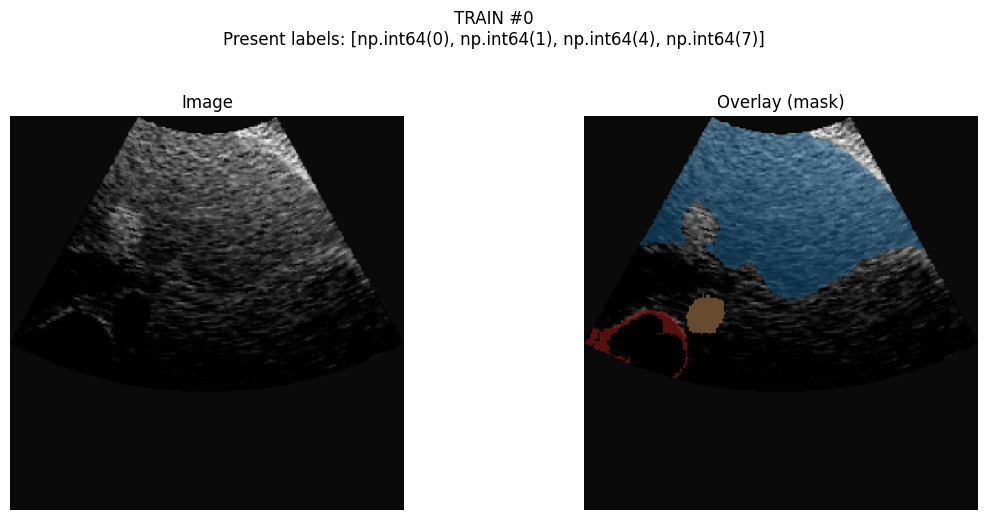

Val sample  :


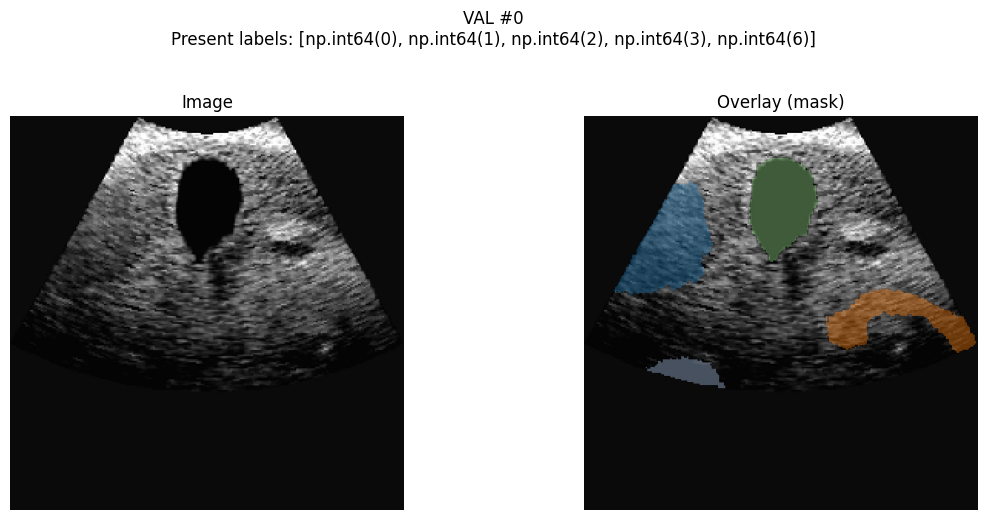

Test sample :


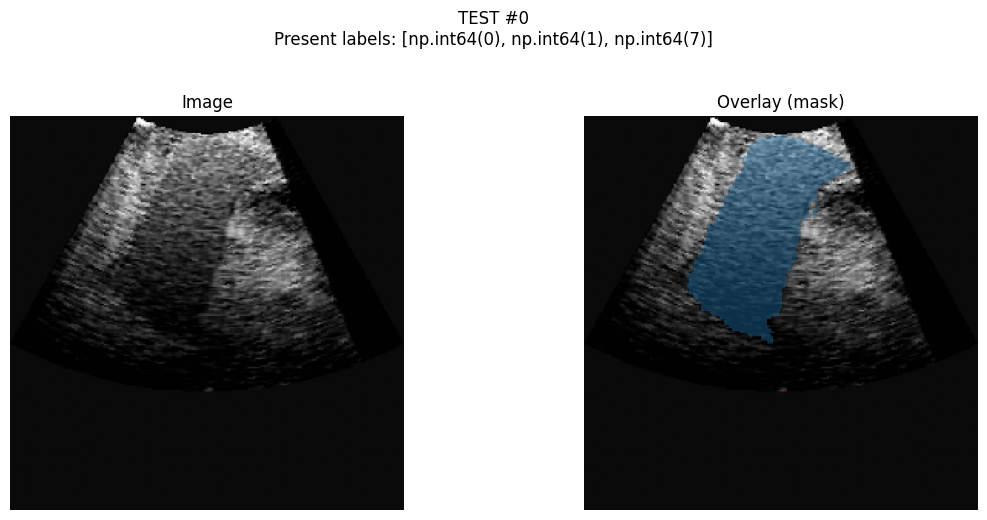

In [ ]:
def to_numpy_image(x):
    if "PIL" in str(type(x)):
        x = np.array(x)
    elif isinstance(x, torch.Tensor):
        x = x.detach().cpu().numpy()
        if x.ndim == 3 and x.shape[0] in (1,3):
            x = np.transpose(x, (1,2,0))
    x = x.astype(np.float32)
    if x.ndim == 2:
        x = np.stack([x, x, x], axis=-1)
    if x.max() > 1.5:
        x /= 255.0
    return x

def to_numpy_mask(m):
    if "PIL" in str(type(m)):
        m = np.array(m)
    elif isinstance(m, torch.Tensor):
        m = m.detach().cpu().numpy()
    return m.astype(np.int64)

from matplotlib.colors import ListedColormap, BoundaryNorm
def build_discrete_cmap(max_label_id):
    base = plt.get_cmap("tab20").colors
    colors = []
    for i in range(max_label_id + 1):
        if i == 0: colors.append((0.85,0.85,0.85))
        else:      colors.append(base[(i-1) % len(base)])
    cmap = ListedColormap(colors)
    norm = BoundaryNorm(np.arange(-0.5, max_label_id+1.5, 1), cmap.N)
    return cmap, norm

def show_image_mask_with_legend(sample, title=None, alpha=0.4):
    if isinstance(sample, (tuple, list)):
        image, mask = sample[0], sample[1]
    else:
        image, mask = sample["image"], sample["mask"]

    img = to_numpy_image(image)
    msk = to_numpy_mask(mask)
    present = np.unique(msk)
    max_id = int(present.max()) if present.size > 0 else 0
    cmap, norm = build_discrete_cmap(max_id)

    fig, axes = plt.subplots(1,2, figsize=(12,5))
    axes[0].imshow(img); axes[0].set_title("Image"); axes[0].axis("off")
    axes[1].imshow(img)
    axes[1].imshow(np.ma.masked_where(msk==0, msk), cmap=cmap, norm=norm, alpha=alpha)
    axes[1].set_title("Overlay (mask)"); axes[1].axis("off")
    if not title: title = "Sample with class legend"
    fig.suptitle(f"{title}\nPresent labels: {list(present)}", y=1.03)
    plt.tight_layout(); plt.show()

print("Train sample:"); show_image_mask_with_legend(train_ds_raw[0], "TRAIN #0")
print("Val sample  :"); show_image_mask_with_legend(val_ds_raw[0],   "VAL #0")
print("Test sample :"); show_image_mask_with_legend(test_ds_raw[0],  "TEST #0")


## **Step 8 🔍 Discover Available Labels**  

To train a segmentation model, we need to know **which labels (classes)** exist in the dataset.  
This step explores the dataset masks to automatically detect them.  

- **`discover_labels(ds, n=300)`**  
  - Iterates through up to *n* samples of a dataset split.  
  - Extracts the unique label IDs present in the segmentation masks.  
  - Collects them into a sorted list.  

- **Label discovery per split**  
  - `labels_train` → labels found in the training set  
  - `labels_val` → labels found in the validation set  
  - `labels_test` → labels found in the test set  

- **Number of classes**  
  - We combine all discovered labels across train/val/test.  
  - The maximum label ID + 1 gives us the total number of segmentation classes → `NUM_CLASSES`.  

🔍 **What to expect after running:**  
- A printed list of label IDs for each dataset split  
- A confirmation line like:  


In [ ]:
def discover_labels(ds, n=300):
    seen = set()
    for i in range(min(n, len(ds))):
        sample = ds[i]
        mask = sample[1] if isinstance(sample, (tuple,list)) else sample["mask"]
        seen.update(np.unique(to_numpy_mask(mask)).tolist())
    return sorted(seen)

labels_train = discover_labels(train_ds_raw, n=500)
labels_val   = discover_labels(val_ds_raw,   n=500)
labels_test  = discover_labels(test_ds_raw,  n=500)
print("Labels (train):", labels_train)
print("Labels (val)  :", labels_val)
print("Labels (test) :", labels_test)

NUM_CLASSES = int(max(labels_train + labels_val + labels_test)) + 1
print("→ NUM_CLASSES inferred:", NUM_CLASSES)


Labels (train): [0, 1, 2, 3, 4, 5, 6, 7, 8]
Labels (val)  : [0, 1, 2, 3, 4, 5, 6, 7, 8]
Labels (test) : [0, 1, 2, 3, 4, 5, 6, 7, 8]
→ NUM_CLASSES inferred: 9


## **Step 9 🛠️ Build a Custom PyTorch Dataset + DataLoader**s  

The raw dataset needs to be adapted into a format that PyTorch can easily work with.  
Here we define a **custom dataset class** and wrap it in `DataLoader`s for batching and shuffling.  

### 🔹 `TorchSegDataset` class  
- Inherits from **`torch.utils.data.Dataset`**.  
- Returns for each sample:  
  - **image** → float tensor `[3, H, W]` with values in `[0, 1]`  
  - **mask** → long tensor `[H, W]` with class labels  

**Key steps inside `__getitem__`:**  
- Convert image/mask into NumPy arrays  
- If grayscale, expand to 3 channels  
- Apply **random flips** (horizontal/vertical) during training for data augmentation  
- Normalize image values to `[0, 1]`  
- Convert to PyTorch tensors in channel-first format  

### 🔹 Create dataset splits  
- `train_ds` → training data with augmentation  
- `val_ds` → validation data (no augmentation)  
- `test_ds` → testing data (no augmentation)  

### 🔹 DataLoaders  
- Batch size = **8**  
- Shuffling only for training set  
- `pin_memory` and `num_workers` configured for GPU acceleration if CUDA is available  

🔍 **What to expect after running:**  
- Three DataLoaders ready: `train_loader`, `val_loader`, `test_loader`  
- Printed output showing how many batches each loader contains.  


In [ ]:
class TorchSegDataset(Dataset):
    """
    Returns:
      image: float tensor [3,H,W] in [0,1]
      mask : long  tensor [H,W]
    """
    def __init__(self, base_ds, train=True):
        self.base = base_ds
        self.train = train

    def __len__(self): return len(self.base)

    def _to_np(self, x):
        if isinstance(x, np.ndarray): return x
        if isinstance(x, torch.Tensor): return x.detach().cpu().numpy()
        return np.array(x)  # PIL -> np

    def __getitem__(self, idx):
        sample = self.base[idx]
        img = sample[0] if isinstance(sample, (tuple, list)) else sample["image"]
        msk = sample[1] if isinstance(sample, (tuple, list)) else sample["mask"]

        img = self._to_np(img)  # HxW or HxWxC
        msk = self._to_np(msk)  # HxW (int labels)

        if img.ndim == 2:
            img = img[..., None]

        # paired flips
        if self.train:
            if random.random() < 0.5:
                img = np.flip(img, axis=1).copy()
                msk = np.flip(msk, axis=1).copy()
            if random.random() < 0.3:
                img = np.flip(img, axis=0).copy()
                msk = np.flip(msk, axis=0).copy()

        img = img.astype(np.float32)
        if img.max() > 1.5:
            img = img / 255.0

        if img.shape[2] == 1:
            img = np.repeat(img, 3, axis=2)

        img_t = torch.from_numpy(img.transpose(2,0,1))   # [C,H,W]
        msk_t = torch.from_numpy(msk.astype(np.int64))    # [H,W]
        return img_t, msk_t

train_ds = TorchSegDataset(train_ds_raw, train=True)
val_ds   = TorchSegDataset(val_ds_raw,   train=False)
test_ds  = TorchSegDataset(test_ds_raw,  train=False)

BATCH_SIZE = 8
pin_mem = torch.cuda.is_available()
num_workers = 2 if pin_mem else 0

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=num_workers, pin_memory=pin_mem)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=num_workers, pin_memory=pin_mem)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=num_workers, pin_memory=pin_mem)

len(train_loader), len(val_loader), len(test_loader)


(72, 8, 37)

## **Step 10 🧠 Build the Attention U-Net Model**  

Now we define our **segmentation model**: an **Attention U-Net (AttUNet)**.  
It’s based on the classic U-Net encoder–decoder architecture but enhanced with attention blocks to focus on the most relevant features.  

### 🔹 Key building blocks  
- **DoubleConv** → two convolutional layers with batch normalization + ReLU (basic feature extractor)  
- **Down** → max-pooling followed by DoubleConv (encoder block)  
- **AttentionBlock** → gates skip connections from encoder to decoder, letting the model “attend” to important spatial regions  
- **UpAtt** → upsampling + attention + DoubleConv (decoder block)  
- **OutConv** → final 1×1 convolution to map features into `n_classes` segmentation channels  

### 🔹 The AttUNet architecture  
- **Encoder (contracting path)**  
  - progressively reduces spatial resolution while increasing feature depth  
- **Bottleneck**  
  - deepest layer capturing global context  
- **Decoder (expanding path)**  
  - progressively upsamples and merges features with encoder skips, guided by attention blocks  
- **Final output**  
  - segmentation logits for each class  

### 🔹 Model instantiation  
- Input channels: **3** (RGB ultrasound images)  
- Output classes: `NUM_CLASSES` (discovered earlier)  
- Bilinear upsampling used in decoder  
- Base channel size = **64**  
- Dropout = **10%** for regularization  
- Moved to the chosen `DEVICE` (GPU if available)  

🔍 **What to expect after running:**  
- A line printing the **number of model parameters (in millions)** → useful for checking model complexity.  


In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch, p_drop=0.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
            nn.Dropout2d(p=p_drop) if p_drop>0 else nn.Identity(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.net(x)

class Down(nn.Module):
    def __init__(self, in_ch, out_ch, p_drop=0.0):
        super().__init__()
        self.pool = nn.MaxPool2d(2)
        self.conv = DoubleConv(in_ch, out_ch, p_drop=p_drop)
    def forward(self, x): return self.conv(self.pool(x))

class AttentionBlock(nn.Module):
    """
    Gates the encoder skip (x) using decoder features (g).
    """
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, bias=False),
            nn.BatchNorm2d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, bias=False),
            nn.BatchNorm2d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, bias=False),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi  # broadcast multiply

class UpAtt(nn.Module):
    def __init__(self, in_ch_dec, in_ch_skip, out_ch, bilinear=True, p_drop=0.0):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch_dec, in_ch_dec, kernel_size=2, stride=2)
        self.att = AttentionBlock(F_g=in_ch_dec, F_l=in_ch_skip, F_int=in_ch_skip // 2)
        self.conv = DoubleConv(in_ch_dec + in_ch_skip, out_ch, p_drop=p_drop)

    def forward(self, g, x_skip):
        g_up = self.up(g)
        # pad if needed
        diffY = x_skip.size(2) - g_up.size(2)
        diffX = x_skip.size(3) - g_up.size(3)
        g_up = F.pad(g_up, [diffX//2, diffX - diffX//2, diffY//2, diffY - diffY//2])
        x_att = self.att(g_up, x_skip)
        x = torch.cat([x_att, g_up], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=1)
    def forward(self, x): return self.conv(x)

class AttUNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=2, bilinear=True, base_ch=64, p_drop=0.0):
        super().__init__()
        factor = 2 if bilinear else 1

        # Encoder
        self.inc   = DoubleConv(n_channels, base_ch, p_drop=p_drop)
        self.down1 = Down(base_ch,   base_ch*2, p_drop=p_drop)
        self.down2 = Down(base_ch*2, base_ch*4, p_drop=p_drop)
        self.down3 = Down(base_ch*4, base_ch*8, p_drop=p_drop)

        # Bottleneck (reduced for bilinear)
        self.down4 = Down(base_ch*8, base_ch*16 // factor, p_drop=p_drop)

        # Decoder with attention on skips
        self.up1 = UpAtt(in_ch_dec=base_ch*16 // factor, in_ch_skip=base_ch*8,
                         out_ch=base_ch*8 // factor, bilinear=bilinear, p_drop=p_drop)
        self.up2 = UpAtt(in_ch_dec=base_ch*8 // factor, in_ch_skip=base_ch*4,
                         out_ch=base_ch*4 // factor, bilinear=bilinear, p_drop=p_drop)
        self.up3 = UpAtt(in_ch_dec=base_ch*4 // factor, in_ch_skip=base_ch*2,
                         out_ch=base_ch*2 // factor, bilinear=bilinear, p_drop=p_drop)
        self.up4 = UpAtt(in_ch_dec=base_ch*2 // factor, in_ch_skip=base_ch,
                         out_ch=base_ch, bilinear=bilinear, p_drop=p_drop)

        self.outc = OutConv(base_ch, n_classes)

    def forward(self, x):
        x1 = self.inc(x)      # 64
        x2 = self.down1(x1)   # 128
        x3 = self.down2(x2)   # 256
        x4 = self.down3(x3)   # 512
        x5 = self.down4(x4)   # 512 (if conv) or 256 (bilinear path)

        x  = self.up1(x5, x4)
        x  = self.up2(x,  x3)
        x  = self.up3(x,  x2)
        x  = self.up4(x,  x1)
        return self.outc(x)

model = AttUNet(n_channels=3, n_classes=NUM_CLASSES, bilinear=True, base_ch=64, p_drop=0.10).to(DEVICE)
print("Params (M):", sum(p.numel() for p in model.parameters())/1e6)


Params (M): 13.742449


## **Step 11 ⚖️ Loss Functions, Metrics & Optimizer**  

To train our segmentation model, we need **loss functions** (for optimization) and **metrics** (for evaluation).  

---

### 🧮 Loss functions  
- **Cross-Entropy Loss (CE)**  
  - Standard pixel-wise classification loss.  
  - We use **class weights** (computed from inverse frequency of labels) so rare organs are not ignored.  
  - Background is kept learnable but weighted down.  

- **Soft Dice Loss**  
  - Measures overlap between predicted segmentation and ground truth.  
  - Especially useful for imbalanced datasets.  
  - We minimize `1 - Dice`.  

🔑 In practice: we often combine CE + Dice loss for stable and balanced training.  

---

### 📊 Metrics  
- **IoU (Intersection-over-Union)**  
  - Overlap between predicted region and ground truth.  
- **Dice Coefficient**  
  - Similar to IoU but more sensitive to small structures.  
- **Ignore Index**  
  - Background (`0`) is excluded from metrics → avoids inflating scores when the model just predicts background.  

---

### ⚡ Optimizer & Training setup  
- Optimizer: **AdamW** (Adam with decoupled weight decay → better generalization)  
- Learning rate: `3e-4`  
- Weight decay: `1e-4`  
- Mixed precision: enabled via `torch.cuda.amp.GradScaler` for faster training on GPU.  

---

✅ **What happens after running this cell:**  
- Class weights are estimated from the training set.  
- `ce_loss` (weighted CrossEntropy) and `soft_dice_loss` are ready.  
- The optimizer + AMP scaler are initialized.  


In [ ]:
def soft_dice_loss(logits, targets, num_classes, eps=1e-6, ignore_index=None):
    N, C, H, W = logits.shape
    probs = F.softmax(logits, dim=1)
    tgt_oh = F.one_hot(torch.clamp(targets, min=0), num_classes=num_classes)  # (N,H,W,C)
    tgt_oh = tgt_oh.permute(0,3,1,2).float()

    if ignore_index is not None:
        valid = (targets != ignore_index).float()
        probs = probs * valid.unsqueeze(1)
        tgt_oh = tgt_oh * valid.unsqueeze(1)

    dims = (0,2,3)
    intersection = torch.sum(probs * tgt_oh, dims)
    cardinality  = torch.sum(probs + tgt_oh, dims)
    dice_per_class = (2. * intersection + eps) / (cardinality + eps)

    if ignore_index is not None and ignore_index < num_classes:
        dice_per_class = dice_per_class[torch.arange(num_classes) != ignore_index]
    return 1.0 - dice_per_class.mean()

def compute_metrics(logits, targets, num_classes, ignore_index=None, eps=1e-6):
    with torch.no_grad():
        preds = torch.argmax(logits, dim=1)
        valid = (targets != ignore_index) if ignore_index is not None else torch.ones_like(targets, dtype=torch.bool)
        ious, dices = [], []
        for cls in range(num_classes):
            if ignore_index is not None and cls == ignore_index:
                continue
            pred_c = (preds == cls) & valid
            targ_c = (targets == cls) & valid
            inter = (pred_c & targ_c).sum().item()
            union = (pred_c | targ_c).sum().item()
            denom = (pred_c.sum() + targ_c.sum()).item()
            iou  = inter / (union + eps)
            dice = (2*inter) / (denom + eps)
            ious.append(iou); dices.append(dice)
        return float(np.mean(ious)) if ious else 0.0, float(np.mean(dices)) if dices else 0.0

# Ignore background in metrics/Dice (helps ultrasound)
IGNORE_INDEX = 0

# Class-weighted CE from inverse frequency
def estimate_class_weights(ds, num_classes, scan_items=200):
    counts = np.zeros(num_classes, dtype=np.float64); total = 0
    for i in range(min(scan_items, len(ds))):
        _, m = ds[i]
        m = m.numpy().ravel()
        bc = np.bincount(m, minlength=num_classes).astype(np.float64)
        counts += bc; total += bc.sum()
    freqs = counts / max(total, 1.0)
    weights = 1.0 / (freqs + 1e-8)
    weights = weights / weights.mean()
    weights = np.clip(weights, 0.2, 5.0)
    return torch.tensor(weights, dtype=torch.float32)

class_weights = estimate_class_weights(train_ds, NUM_CLASSES).to(DEVICE)
ce_loss = nn.CrossEntropyLoss(weight=class_weights)  # keep bg learnable

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE=="cuda"))


/tmp/ipython-input-476644137.py:60: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE=="cuda"))


## **🔄 Step 12: Training & Evaluation Loop**  

This function `run_epoch()` is the engine that runs **one full pass** over the dataset — either in **training mode** or **evaluation mode**. Let’s break it down:

1. ⚙️ **Mode Setting**  
   - If `train_mode=True`, the model is set to training mode (`model.train()`), meaning it will update weights.  
   - Otherwise, it switches to evaluation mode (`torch.inference_mode()`), so no weights are updated.  

2. 📥 **Batch Processing**  
   - For each batch of input images (`xb`) and masks (`yb`), data is moved to the GPU/CPU (`DEVICE`).  

3. 🎯 **Forward Pass & Loss Calculation**  
   - The model predicts segmentation maps (`logits`).  
   - Two losses are combined:  
     - Cross Entropy Loss (measures pixel-wise classification errors).  
     - Soft Dice Loss (measures overlap quality).  
   - Together, they encourage both accurate boundaries and correct region classification.  

4. 📊 **Metrics Tracking**  
   - After every batch, performance is evaluated using:  
     - **mIoU** (mean Intersection over Union).  
     - **mDice** (mean Dice Score).  
   - These metrics are accumulated to get epoch-level averages.  

5. 🏋️ **Backward Pass (only in training)**  
   - If training, gradients are computed and the optimizer updates the model’s weights.  
   - Gradient scaling (`scaler`) is used for **mixed precision training**, which makes training faster and more memory-efficient on GPUs.  

6. 📈 **Return Epoch Statistics**  
   - At the end of the loop, the function returns the **average loss, mIoU, and mDice** for the entire epoch.  

✨ In short: This function is the heartbeat of the pipeline — it handles both **training updates**


In [ ]:
def run_epoch(loader, train_mode=True):
    model.train(train_mode)
    running_loss = running_miou = running_mdice = 0.0
    count = 0

    if train_mode:
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE, non_blocking=True), yb.to(DEVICE, non_blocking=True)
            optimizer.zero_grad(set_to_none=True)
            with torch.amp.autocast("cuda", enabled=(DEVICE=="cuda")):
                logits = model(xb)
                loss = ce_loss(logits, yb) + soft_dice_loss(logits, yb, NUM_CLASSES, ignore_index=IGNORE_INDEX)
            miou, mdice = compute_metrics(logits, yb, NUM_CLASSES, ignore_index=IGNORE_INDEX)
            running_loss += loss.item(); running_miou += miou; running_mdice += mdice; count += 1
            scaler.scale(loss).backward(); scaler.step(optimizer); scaler.update()
    else:
        with torch.inference_mode():
            for xb, yb in loader:
                xb, yb = xb.to(DEVICE, non_blocking=True), yb.to(DEVICE, non_blocking=True)
                with torch.amp.autocast("cuda", enabled=(DEVICE=="cuda")):
                    logits = model(xb)
                    loss = ce_loss(logits, yb) + soft_dice_loss(logits, yb, NUM_CLASSES, ignore_index=IGNORE_INDEX)
                miou, mdice = compute_metrics(logits, yb, NUM_CLASSES, ignore_index=IGNORE_INDEX)
                running_loss += loss.item(); running_miou += miou; running_mdice += mdice; count += 1

    return running_loss / count, running_miou / count, running_mdice / count

## **🏋️ Step 13: Training Loop with Scheduler, Early Stopping & History**  

This block trains the Attention U-Net model over multiple epochs while tracking progress, adjusting learning rate, and preventing overfitting. Let’s break it down:

---

#### 📖 1. History Tracking
A dictionary `history` is created to store loss, mIoU, and mDice values for both **training** and **validation** across epochs.  
- This will later be saved as `.npz` and `.json` for reproducibility and visualization.

---

#### ⏳ 2. Epoch Configuration
- `EPOCHS = 100`: maximum number of training iterations.  
- `best_val_dice`: keeps track of the **best validation Dice score** seen so far.  
- Paths are defined to save the **best model** and training history files.

---

#### 📉 3. Learning Rate Scheduler
- Uses `ReduceLROnPlateau`, which automatically reduces the **learning rate** if validation performance (mDice) stops improving.  
- Factor = `0.5`: learning rate is halved after patience is reached.  
- Patience = `4`: waits for 4 stagnant epochs before adjusting.

---

#### 🛑 4. Early Stopping
- Patience = `8`: if validation Dice does not improve for 8 epochs, training stops early.  
- Prevents overfitting and saves compute.

---

#### 🔄 5. Main Training Loop
For each epoch:  
1. **Training Phase**  
   - Calls `run_epoch(train_loader, train_mode=True)` → updates model weights.  

2. **Validation Phase**  
   - Calls `run_epoch(val_loader, train_mode=False)` → evaluates performance without updating weights.  

3. **Logging & Tracking**  
   - Records loss, mIoU, and mDice in the history dictionary.  
   - Prints progress in a structured format:  
     ```
     [01/100] 23.5s | Train: loss=... mIoU=... mDice=... || Val: ...
     ```

4. **Model Checkpointing**  
   - If current validation Dice is the best so far, the model weights are saved (`.pt`).  
   - Otherwise, `stale` counter increases (used for early stopping).

5. **Scheduler Update**  
   - Adjusts learning rate based on validation Dice trend.

---

#### 💾 6. Saving History
At the end (or upon early stopping):  
- Training history is saved as:  
  - `.npz` (NumPy format for fast reload).  
  - `.json` (human-readable for external analysis).  
- ✅ Ensures reproducibility and future visualization.

---

✨ **In short**:  
This loop is robust — it trains the model while automatically adjusting learning rate 📉, saves the best checkpoint 💾, stops when validation stagnates 🛑, and logs everything for later 📊.


In [ ]:


# Training loop with history/scheduler/early-stop
import time
history = {"epoch": [], "train_loss": [], "train_miou": [], "train_mdice": [],
           "val_loss": [], "val_miou": [], "val_mdice": []}

EPOCHS = 100
best_val_dice = -1.0
best_path = "/content/attunet_abdomenus_best.pt"
hist_npz = "/content/attunet_training_history.npz"
hist_json = "/content/attunet_training_history.json"

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", factor=0.5, patience=4   # <- no verbose
)

patience = 8
stale = 0

for epoch in range(1, EPOCHS+1):
    t0 = time.time()
    tr_loss, tr_miou, tr_mdice = run_epoch(train_loader, train_mode=True)
    va_loss, va_miou, va_mdice = run_epoch(val_loader,   train_mode=False)
    dt = time.time() - t0

    history["epoch"].append(epoch)
    history["train_loss"].append(tr_loss); history["train_miou"].append(tr_miou); history["train_mdice"].append(tr_mdice)
    history["val_loss"].append(va_loss);   history["val_miou"].append(va_miou);   history["val_mdice"].append(va_mdice)

    print(f"[{epoch:02d}/{EPOCHS}] {dt:5.1f}s | "
          f"Train: loss={tr_loss:.4f} mIoU={tr_miou:.4f} mDice={tr_mdice:.4f} || "
          f"Val: loss={va_loss:.4f} mIoU={va_miou:.4f} mDice={va_mdice:.4f}")

    scheduler.step(va_mdice)
    if va_mdice > best_val_dice:
        best_val_dice = va_mdice
        torch.save({"model": model.state_dict(), "num_classes": NUM_CLASSES, "size": SIZE}, best_path)
        print(f"  ↪︎ Saved best (val mDice={best_val_dice:.4f}) -> {best_path}")
        stale = 0
    else:
        stale += 1
        if stale >= patience:
            print(f"Early stopping (no val mDice gain for {patience} epochs).")
            break

# Save history
np.savez(hist_npz, **history)
with open(hist_json, "w") as f:
    json.dump(history, f, indent=2)
print("✅ Saved history:", hist_npz, "and", hist_json)


[01/100]  19.2s | Train: loss=2.2487 mIoU=0.0796 mDice=0.1013 || Val: loss=3.2988 mIoU=0.0835 mDice=0.0992
  ↪︎ Saved best (val mDice=0.0992) -> /content/attunet_abdomenus_best.pt
[02/100]  16.2s | Train: loss=1.7370 mIoU=0.0787 mDice=0.0998 || Val: loss=1.5426 mIoU=0.1144 mDice=0.1482
  ↪︎ Saved best (val mDice=0.1482) -> /content/attunet_abdomenus_best.pt
[03/100]  16.0s | Train: loss=1.5220 mIoU=0.0995 mDice=0.1296 || Val: loss=1.4390 mIoU=0.1230 mDice=0.1722
  ↪︎ Saved best (val mDice=0.1722) -> /content/attunet_abdomenus_best.pt
[04/100]  16.0s | Train: loss=1.4002 mIoU=0.1523 mDice=0.2053 || Val: loss=1.2724 mIoU=0.2124 mDice=0.2765
  ↪︎ Saved best (val mDice=0.2765) -> /content/attunet_abdomenus_best.pt
[05/100]  15.7s | Train: loss=1.2980 mIoU=0.1931 mDice=0.2491 || Val: loss=1.3167 mIoU=0.1786 mDice=0.2326
[06/100]  15.7s | Train: loss=1.2641 mIoU=0.1967 mDice=0.2559 || Val: loss=1.2160 mIoU=0.2114 mDice=0.2755
[07/100]  15.8s | Train: loss=1.2189 mIoU=0.2215 mDice=0.2896 || V

## **🧪 Step 14: Final Model Evaluation on Test Set**  

Now that we have trained and validated our DeepLabV3 segmentation model, it's time for the **ultimate test** — evaluating it on the **unseen test dataset**.  

Here’s what happens in this step:  

- 📂 **Load Best Checkpoint**: The model weights are restored from the checkpoint where it performed best on validation.  
- 🔄 **Test-Time Augmentation (TTA)**: To make predictions more robust, we use a simple trick — horizontal flipping. The model predicts once normally, once on the flipped input (and flips back), then averages the results.  
- 📉 **Loss Computation**: The evaluation uses a mix of **Cross Entropy Loss** and **Soft Dice Loss** to balance pixel-wise accuracy with region overlap quality.  
- 📊 **Metric Calculation**: For each batch, we compute  
  - **mIoU (Mean Intersection over Union)** 🟦  
  - **mDice (Mean Dice Coefficient)** 🟩  
- 🏁 **Final Results**: After going through the entire test set, we print the **average loss, mIoU, and mDice**, which serve as the final performance indicators of our trained model.  

✨ This step gives us a reliable measure of how well the model generalizes to completely new images.


In [ ]:
ckpt = torch.load(best_path, map_location=DEVICE)
model.load_state_dict(ckpt["model"])
model.eval()

def logits_with_tta(xb):
    with torch.no_grad(), torch.amp.autocast("cuda", enabled=(DEVICE=="cuda")):
        p1 = model(xb)
        p2 = model(torch.flip(xb, dims=[3])); p2 = torch.flip(p2, dims=[3])
        return (p1 + p2) / 2

test_loss = test_miou = test_mdice = 0.0
count = 0
with torch.inference_mode():
    for xb, yb in test_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        with torch.amp.autocast("cuda", enabled=(DEVICE=="cuda")):
            logits = logits_with_tta(xb)  # or model(xb)
            loss = ce_loss(logits, yb) + soft_dice_loss(logits, yb, NUM_CLASSES, ignore_index=IGNORE_INDEX)
        miou, mdice = compute_metrics(logits, yb, NUM_CLASSES, ignore_index=IGNORE_INDEX)
        test_loss += loss.item(); test_miou += miou; test_mdice += mdice; count += 1

print(f"TEST: loss={test_loss/count:.4f} | mIoU={test_miou/count:.4f} | mDice={test_mdice/count:.4f}")


TEST: loss=0.8844 | mIoU=0.4906 | mDice=0.5674


## **🎨 Step 15: Visualizing Model Predictions with Overlay**

To better understand how our segmentation model is performing, we’ll visualize predictions by overlaying them on the original input images.  

### 🔍 What this function does:
- **Selects random samples** from the dataset.  
- **Runs inference** on the chosen images using our trained model.  
- **Applies a color map** to both the ground truth and predicted masks.  
- **Overlays the masks** on the original image for side-by-side comparison.  

### 📊 Output:
For each selected sample, we get three panels:
1. 🖼️ **Original Image**  
2. 🎯 **Ground Truth Mask** (overlayed on the image)  
3. 🤖 **Model Prediction Mask** (overlayed on the image)  

This side-by-side view makes it easy to spot where the model aligns well with the ground truth and where it struggles.  

Finally, we preview the model’s predictions on a few validation images using:

```python
# Preview predictions with overlays on the validation set
predict_overlay(val_ds, n=4)


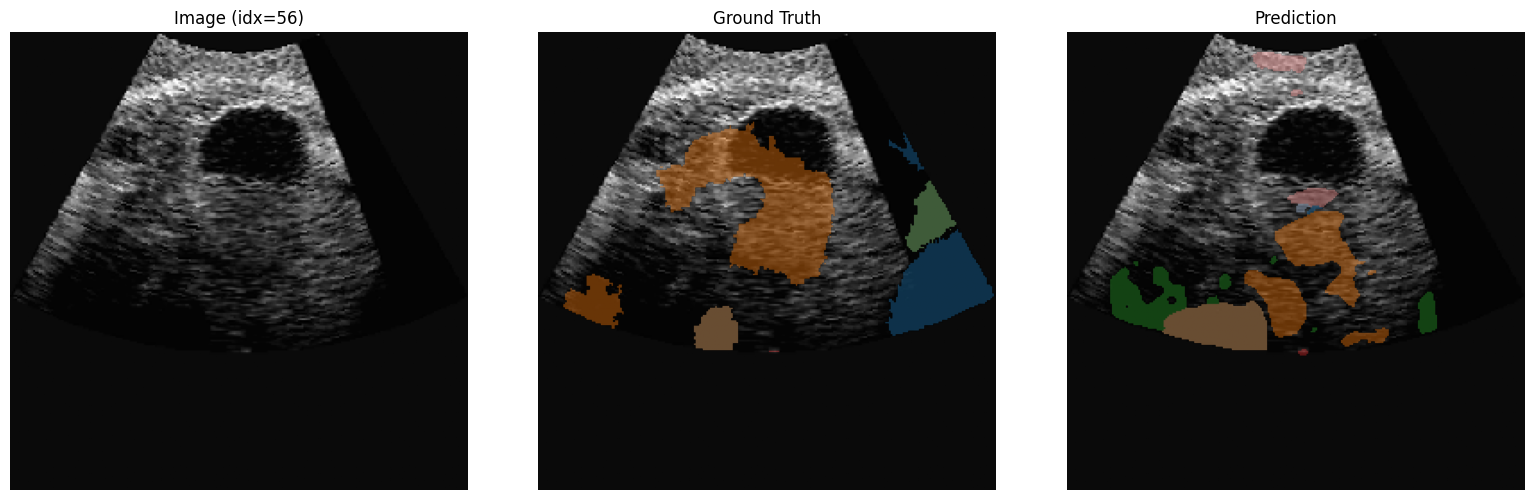

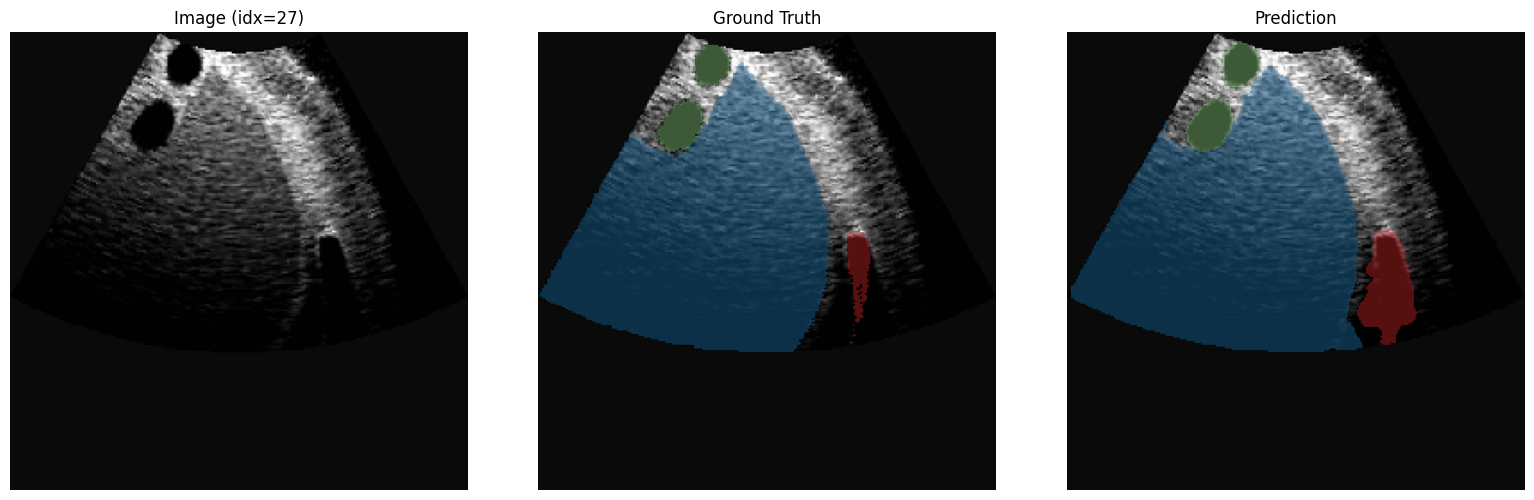

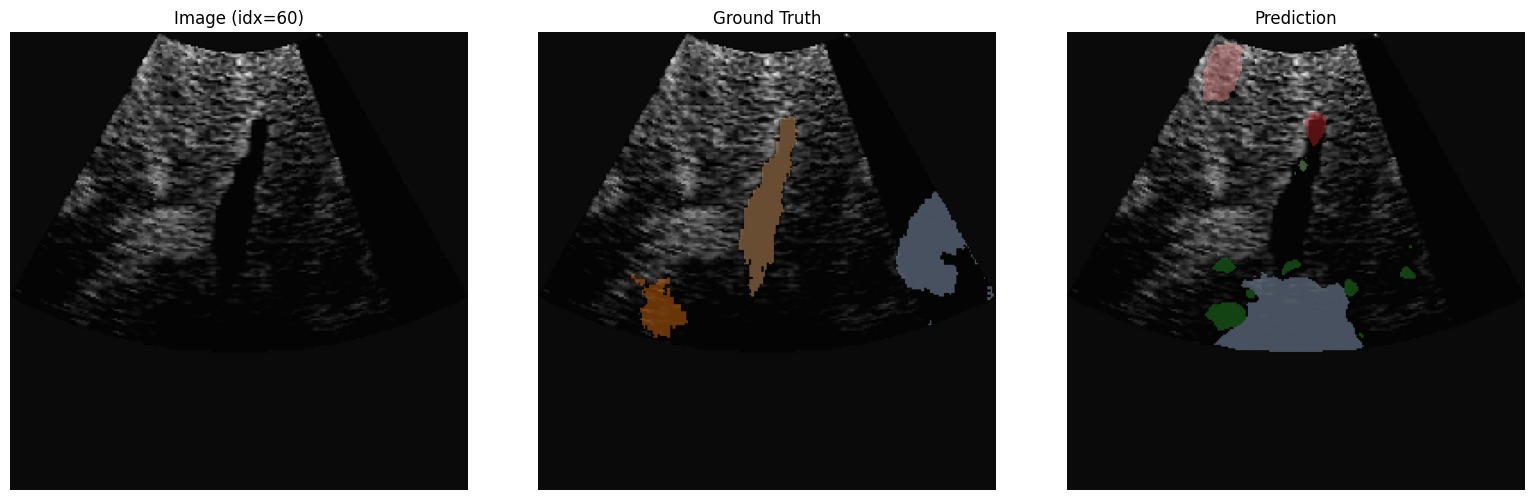

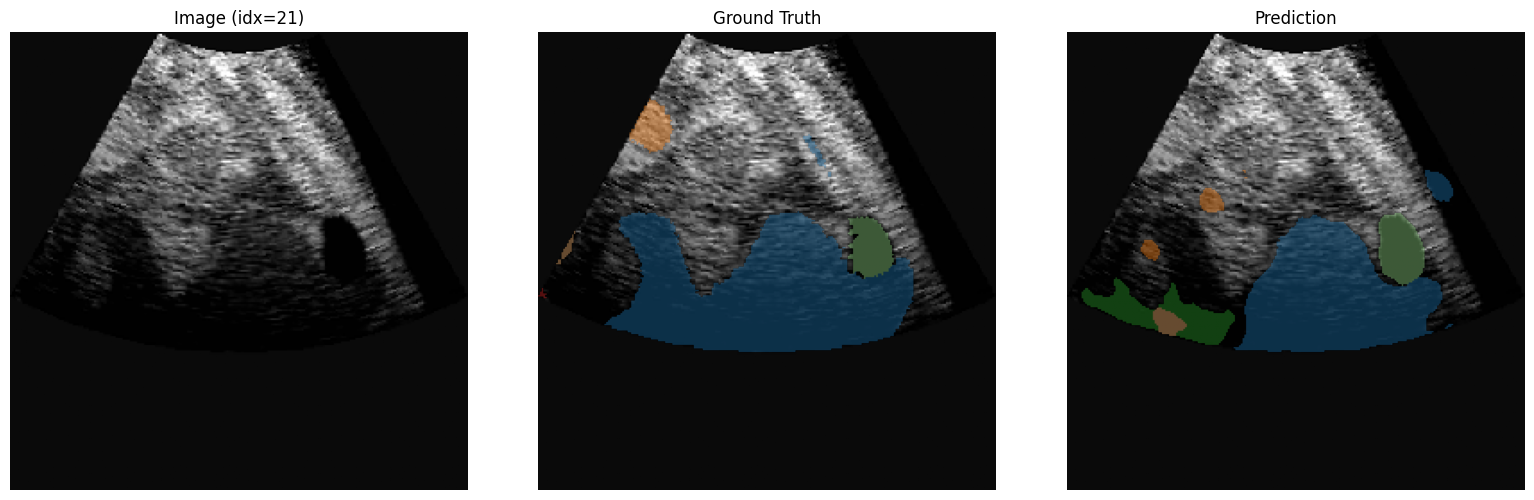

In [ ]:
def predict_overlay(ds, n=3, alpha=0.4):
    model.eval()
    idxs = random.sample(range(len(ds)), k=min(n, len(ds)))
    for i in idxs:
        img_t, msk_t = ds[i]
        with torch.no_grad(), torch.amp.autocast("cuda", enabled=(DEVICE=="cuda")):
            logits = model(img_t.unsqueeze(0).to(DEVICE))
            pred = torch.argmax(logits, dim=1).squeeze(0).cpu().numpy()

        img_np = np.transpose(img_t.numpy(), (1,2,0))
        msk_np = msk_t.numpy()
        max_id = int(max(msk_np.max(), pred.max()))
        cmap, norm = build_discrete_cmap(max_id)

        fig, axes = plt.subplots(1,3, figsize=(16,5))
        axes[0].imshow(img_np); axes[0].set_title(f"Image (idx={i})"); axes[0].axis("off")
        axes[1].imshow(img_np); axes[1].imshow(np.ma.masked_where(msk_np==0, msk_np), cmap=cmap, norm=norm, alpha=alpha); axes[1].set_title("Ground Truth"); axes[1].axis("off")
        axes[2].imshow(img_np); axes[2].imshow(np.ma.masked_where(pred==0, pred),     cmap=cmap, norm=norm, alpha=alpha); axes[2].set_title("Prediction");   axes[2].axis("off")
        plt.tight_layout(); plt.show()

# Preview on validation set
predict_overlay(val_ds, n=4)


## **📊 Step 16: Visualizing Training History**  

Now that our Attention U-Net model has been trained, let’s take a closer look at how it performed over the training epochs.  

- We define a helper function `plot_metric` to visualize training vs. validation curves.  
- Metrics plotted include:  
  - **Loss** → Measures how well the model is fitting the data.  
  - **Mean Intersection over Union (mIoU)** → Evaluates segmentation overlap between predicted and true masks.  
  - **Mean Dice Score (mDice)** → Another key metric for segmentation performance, focusing on overlap accuracy.  
- Each plot helps us check if the model is **learning steadily**, and whether it is **overfitting or underfitting**.  

✅ The plots are also saved as PNG files in `/content/attunet_plot_*.png` for later reference.  


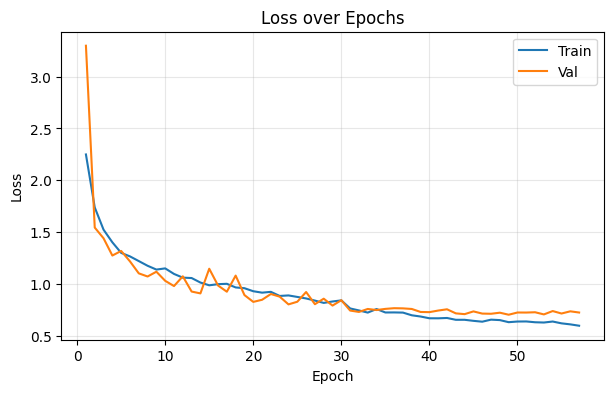

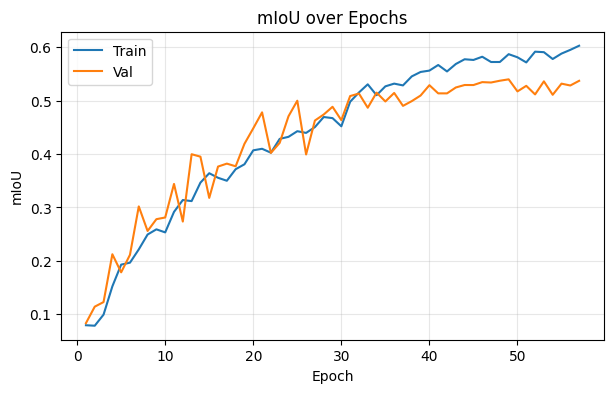

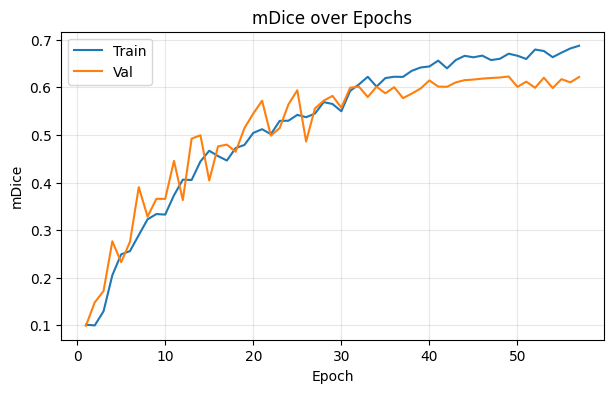

Saved plots to /content/attunet_plot_*.png


In [ ]:
# Load if needed (fresh session):
# data = np.load("/content/attunet_training_history.npz", allow_pickle=True)
# history = {k: data[k].tolist() for k in data.files}

epochs = history["epoch"]

def plot_metric(epochs, train_vals, val_vals, title, ylabel, save_path=None):
    plt.figure(figsize=(7,4))
    plt.plot(epochs, train_vals, label="Train")
    plt.plot(epochs, val_vals,   label="Val")
    plt.xlabel("Epoch"); plt.ylabel(ylabel); plt.title(title)
    plt.grid(True, alpha=0.3); plt.legend()
    if save_path:
        plt.savefig(save_path, bbox_inches="tight", dpi=150)
    plt.show()

plot_metric(epochs, history["train_loss"], history["val_loss"], "Loss over Epochs", "Loss", "/content/attunet_plot_loss.png")
plot_metric(epochs, history["train_miou"], history["val_miou"], "mIoU over Epochs", "mIoU", "/content/attunet_plot_mIoU.png")
plot_metric(epochs, history["train_mdice"], history["val_mdice"], "mDice over Epochs", "mDice", "/content/attunet_plot_mDice.png")
print("Saved plots to /content/attunet_plot_*.png")
